# Exploratory Data Analysis
    * Investigate distributions of features in the merged dataset
    * The dataset was formed in *ingestion.ipynb* by merging four datasets
        * Adjusted Cohort Graduation Rate from EdFacts
        * School Directory from Common Core of Data
        * Math and Reading State Assessment Participation from EdFacts
        * County Unemployment Data from 2000-2020 from USDA

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from swampy import structshape as ss
import missingno


In [2]:
df = pd.read_csv("../data/dataset_from_ingestion.csv")


In [3]:
pd.set_option('display.max_columns', 99)
df.head(n=3)


,Year,Stnam,Fipst,Leaid,Leanm,Ncessch,Schnam,All_Cohort,School_Name,Zip_Mailing,Zip_Location,Latitude,Urban_Centric_Locale,County_Code,School_Level,School_Type,Lowest_Grade_Offered,Highest_Grade_Offered,Title_I_Status,Title_I_Eligible,Charter,Magnet,Virtual,Teachers_Fte,Free_Lunch,Reduced_Price_Lunch,Free_Or_Reduced_Price_Lunch,Enrollment,Ungrade_Cedp,Math_Pct_Part,Rla_Pct_Part,Rural_Urban_Continuum_Code,Urban_Influence_Code,Metro_Or_Not,Civilian_Labor_Force,Unemployment_Rate,Grad_Rate
0,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100208,Bethel Regional High School,75,BETHEL REGIONAL HIGH SCHOOL,99559.0,99559.0,60.802584,41.0,2050.0,4.0,1.0,6.0,12.0,5.0,1.0,0.0,0.0,0.0,32.849998,210.0,28.0,238.0,506.0,0.0,97.5,97.5,7.0,11.0,0.0,7193.0,15.6,52.0
1,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100318,Bethel Alternative Boarding School,28,BETHEL ALTERNATIVE BOARDING SCHOOL,99559.0,99559.0,60.795960,33.0,2050.0,3.0,4.0,8.0,12.0,5.0,1.0,0.0,0.0,0.0,4.000000,58.0,0.0,58.0,61.0,0.0,90.0,90.0,7.0,11.0,0.0,7193.0,15.6,10.0
2,2012,ALASKA,2,200006,Mount Edgecumbe High School Agency,20000600558,Mt. Edgecumbe High School,71,MT. EDGECUMBE HIGH SCHOOL,99835.0,99835.0,57.051810,41.0,2220.0,3.0,1.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,22.500000,224.0,35.0,259.0,398.0,0.0,97.5,97.5,7.0,11.0,0.0,4627.0,5.7,97.5


In [4]:
df.shape, df.dtypes


((83658, 37),
 Year                             int64
 Stnam                           object
 Fipst                            int64
 Leaid                            int64
 Leanm                           object
 Ncessch                          int64
 Schnam                          object
 All_Cohort                       int64
 School_Name                     object
 Zip_Mailing                    float64
 Zip_Location                   float64
 Latitude                       float64
 Urban_Centric_Locale           float64
 County_Code                    float64
 School_Level                   float64
 School_Type                    float64
 Lowest_Grade_Offered           float64
 Highest_Grade_Offered          float64
 Title_I_Status                 float64
 Title_I_Eligible               float64
 Charter                        float64
 Magnet                         float64
 Virtual                        float64
 Teachers_Fte                   float64
 Free_Lunch               

# Descriptive Statistics

Mean 82.56869635898539 Std 19.44663886885491 Median 90.0


Text(0.5, 1.0, 'Graduation Rate Cumulative Probability')

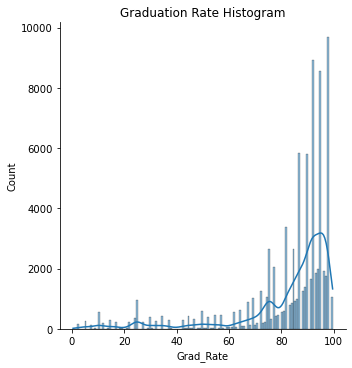

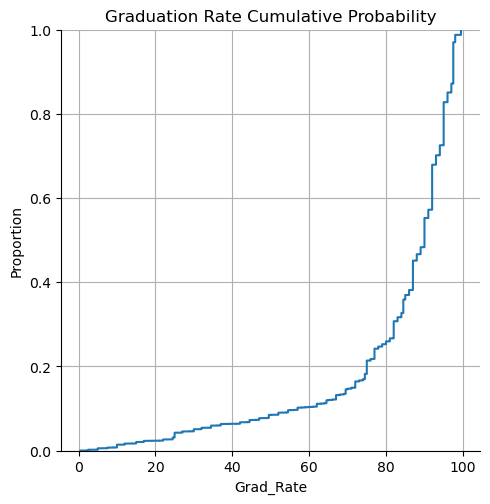

In [5]:
mean = df.Grad_Rate.describe()[1]
std = df.Grad_Rate.describe()[2]
median = df.Grad_Rate.describe()[5]
print("Mean", mean, "Std", std, "Median", median)
sns.color_palette("tab10")
sns.displot(df.Grad_Rate, kde=True)
plt.title("Graduation Rate Histogram")
sns.displot(df.Grad_Rate, kind='ecdf')
plt.grid(visible=True)
plt.title("Graduation Rate Cumulative Probability")


* Our target variable has a strong left-skew.
* The mean is 82.5 and the median is 90.  

Mean 199.59893853546583 Std 189.71605738700393 Median 126.0 80% 354.0


Text(0.5, 1.0, 'Cohort Size Cumulative Probability')

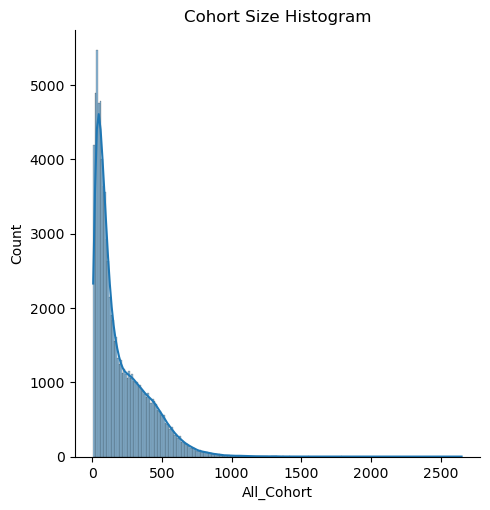

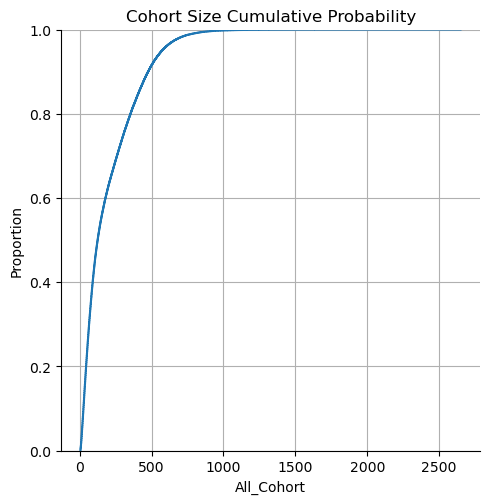

In [6]:
mean = df.All_Cohort.describe()[1]
std = df.All_Cohort.describe()[2]
median = df.All_Cohort.describe()[5]
print("Mean", mean, "Std", std, "Median", median, "80%", np.percentile(df.All_Cohort,80))
sns.displot(df.All_Cohort, kde=True)
plt.title("Cohort Size Histogram")
sns.displot(df.All_Cohort, kind='ecdf')
plt.grid(visible=True)
plt.title("Cohort Size Cumulative Probability")

In [7]:
df.All_Cohort.describe()

count    83658.000000
mean       199.598939
std        189.716057
min          6.000000
25%         55.000000
50%        126.000000
75%        305.000000
max       2651.000000
Name: All_Cohort, dtype: float64

80% of schools have a cohort size under ~354; Max is 2651 and Min is 6.


# Instance Distribution By State

Text(0.5, 1.0, 'Instances per State')

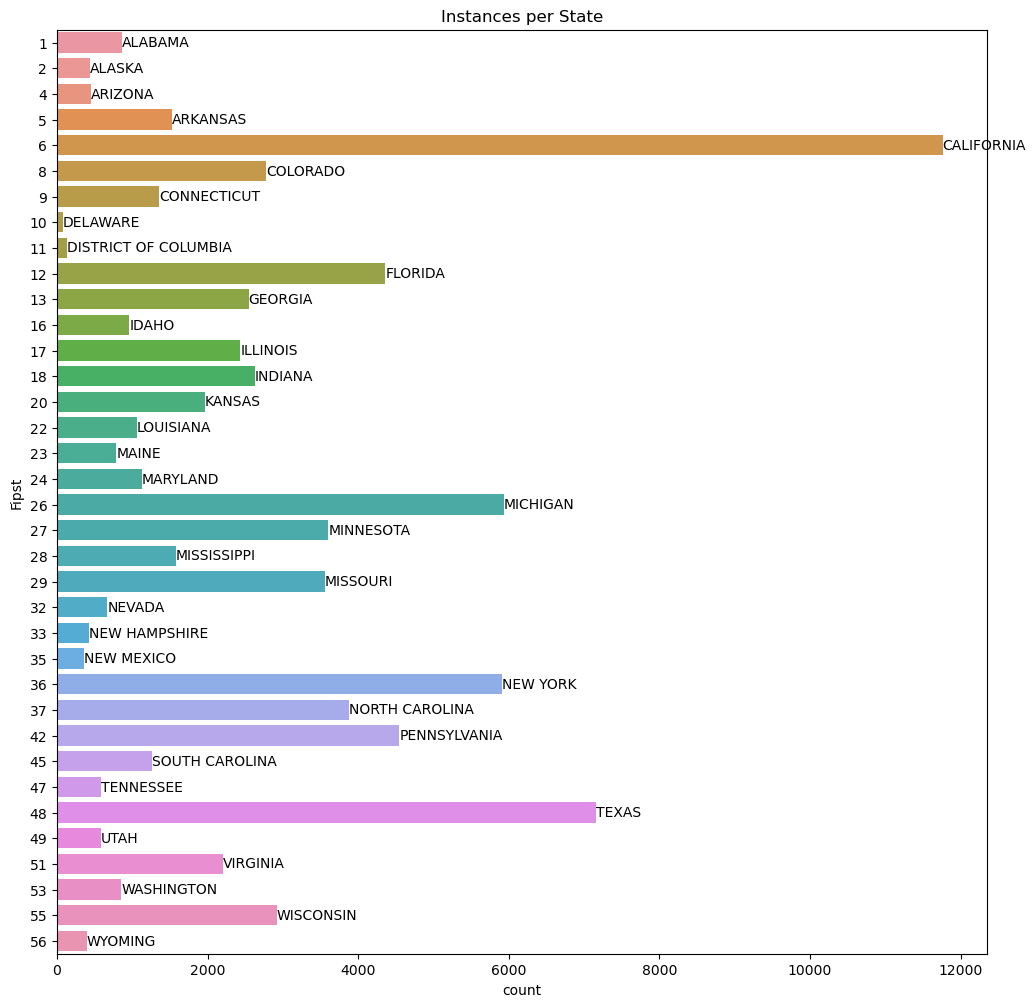

In [8]:
def create_fipst_to_stnam_dict(df):
    """
    Verify that state codes match state names in a one-to-one fashion. 
    Return dictionary mapping FIPST to STNAM.
    """
    fipst_to_name = {}
    for fipst, name in zip(df.Fipst, df.Stnam):
        if fipst in fipst_to_name:
            try:
                assert name == fipst_to_name[fipst]
            except:
                print("found name {} for fipst {} but {} was in dictionary already".format(
                    name, fipst, fipst_to_name[fipst]))
        else:
            fipst_to_name[fipst] = name
    return fipst_to_name


fipst_to_name = create_fipst_to_stnam_dict(df)


plt.rcParams['figure.figsize'] = (12, 12)
ax = sns.countplot(y=df.Fipst)
labels = sorted(fipst_to_name.items())
labels = [v for k, v in labels]
ax.bar_label(container=ax.containers[0], labels=labels)
plt.title("Instances per State")


# Math and Reading State Assessment Participation

Text(0.5, 0, 'Percent Participated')

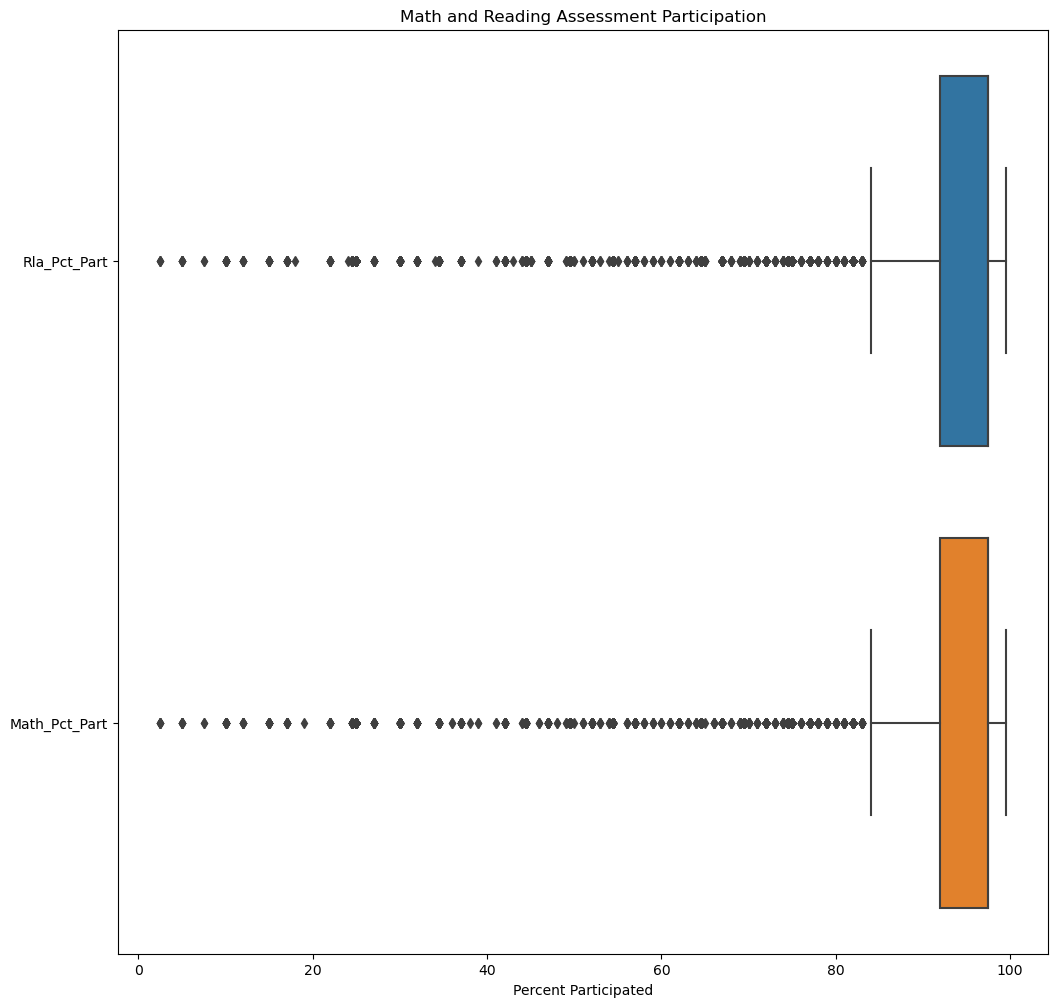

In [9]:
df.Math_Pct_Part.describe(), df.Rla_Pct_Part.describe()

sns.boxplot(data=df[["Rla_Pct_Part", "Math_Pct_Part"]], orient="h")
plt.title("Math and Reading Assessment Participation")
plt.xlabel("Percent Participated")


Text(0, 0.5, 'Percent Difference Math and Reading Participation')

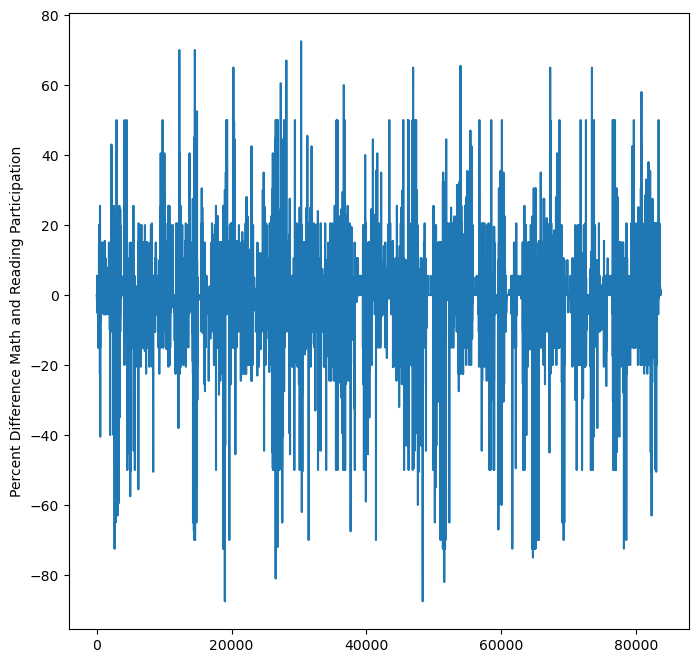

In [10]:
# For State proficiency test taking, does Math Percent Participation equal
# Reading and Language Arts Percent Participation?
plt.rcParams["figure.figsize"] = (8, 8)
plt.plot(df.Math_Pct_Part - df.Rla_Pct_Part)
plt.ylabel("Percent Difference Math and Reading Participation")

# Urban Centric Locale feature
* 11—City, large
* 12—City, midsize
* 13—City, small
* 21—Suburb, large
* 22—Suburb, midsize
* 23—Suburb, small
* 31—Town, fringe
* 32—Town, distant
* 33—Town, remote
* 41—Rural, fringe
* 42—Rural, distant
* 43—Rural, remote

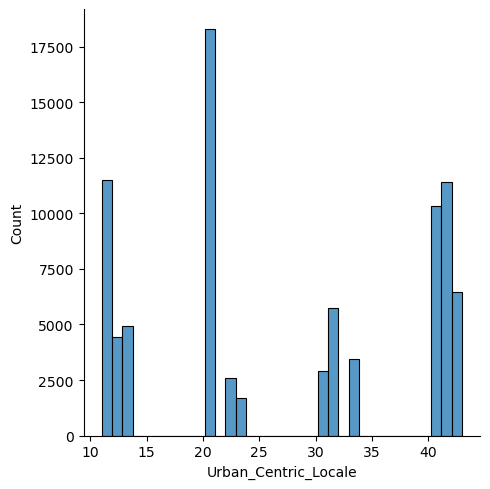

In [11]:
# Look at urban district distribution. This feature describes how rural a location is.
sns.displot(df.Urban_Centric_Locale)

In [12]:
# What is is graduation rate average for each urban centric locale?
urban_centric_list_of_tuples = [(name, df.Grad_Rate.mean())
 for name, df in df.groupby('Urban_Centric_Locale')]

/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Mean Graduation Rate by  (11.0 = Large City)')

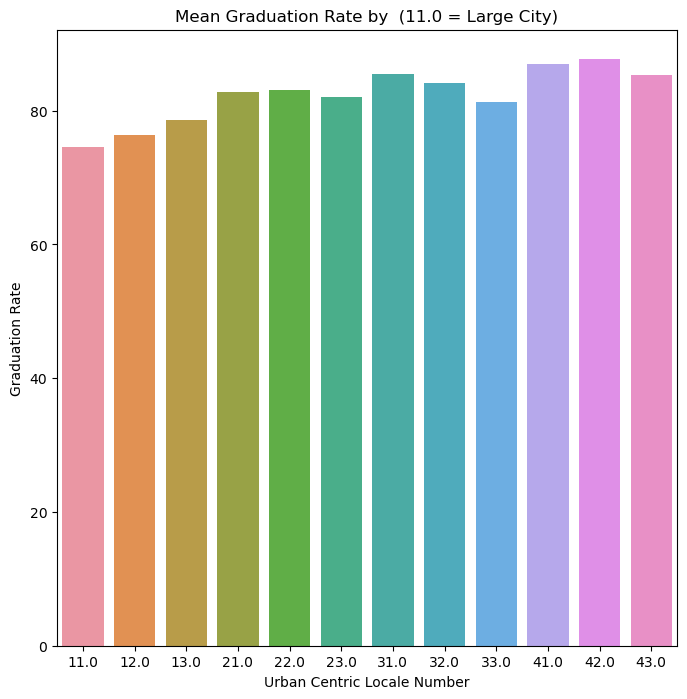

In [13]:
urban_centric = []
mean_grad_rate = []
for tup0,tup1 in urban_centric_list_of_tuples:
    urban_centric += [tup0]
    mean_grad_rate += [tup1]

sns.barplot(urban_centric,mean_grad_rate)
plt.ylabel("Graduation Rate")
plt.xlabel("Urban Centric Locale Number")
plt.title("Mean Graduation Rate by  (11.0 = Large City)")

# Example of a Rare Label

<AxesSubplot:xlabel='Ungrade_Cedp', ylabel='Count'>

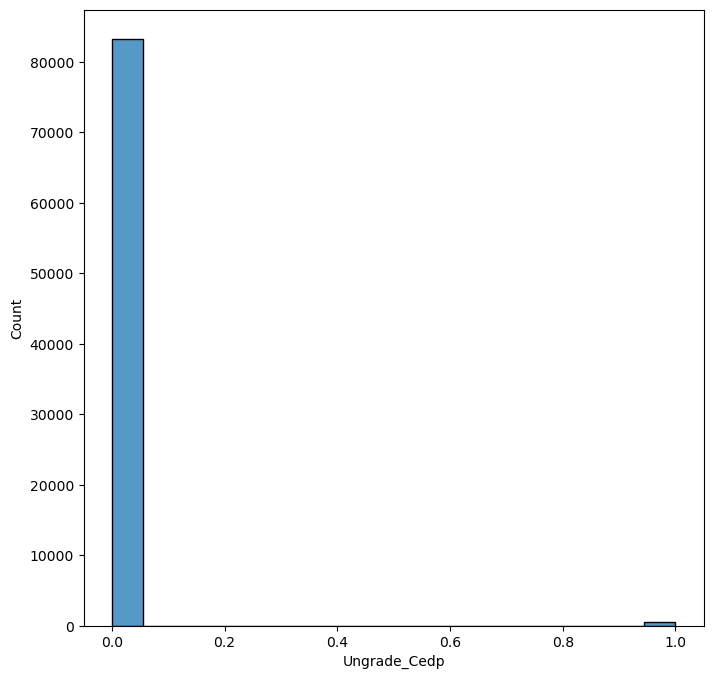

In [14]:
sns.histplot(df.Ungrade_Cedp)

In [15]:
# What is is graduation rate average for graded versus ungraded schools?
[(name, df.Grad_Rate.mean()) for name, df in df.groupby('Ungrade_Cedp')]

[(0.0, 82.5223094116516), (1.0, 91.30203619909503)]

# School Type
* 1—Regular school
* 2—Special education school
* 3—Vocational school
* 4—Other/alternative school

<AxesSubplot:title={'center':'Grad Rate by School Type'}, xlabel='School_Type', ylabel='Grad_Rate'>

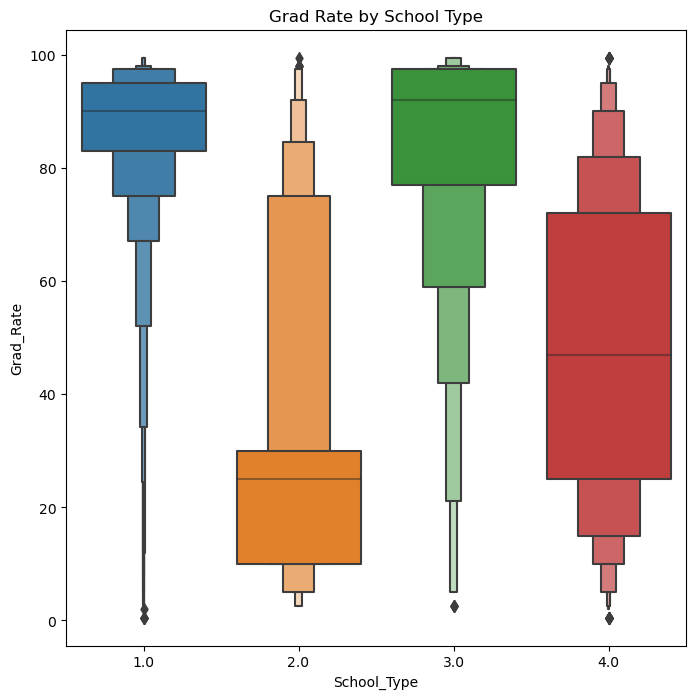

In [16]:
plt.title("Grad Rate by School Type")
sns.boxenplot(x=df.School_Type,y=df.Grad_Rate)

/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='School_Type', ylabel='count'>

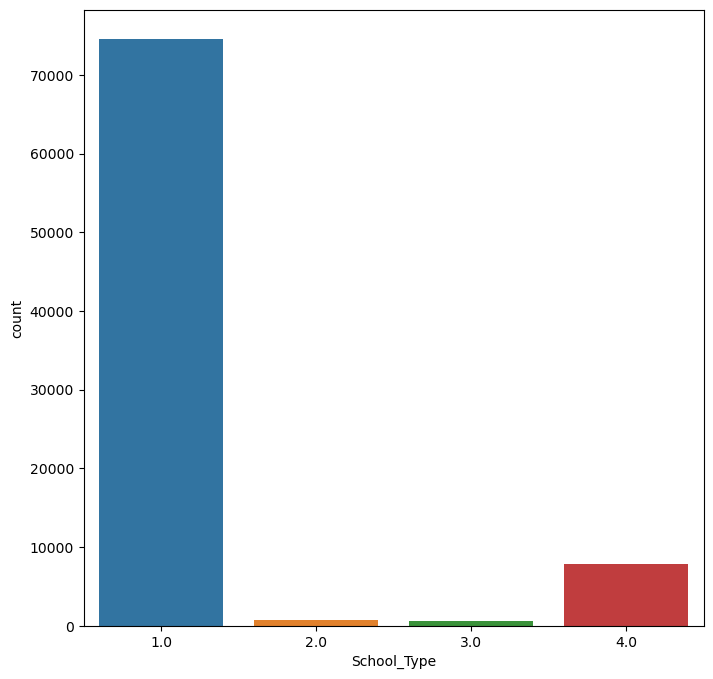

In [17]:
sns.countplot(df.School_Type)

# Year
* We merge the years together in our dataset but want to see the distribution of years in the final dataset that we model

/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Year', ylabel='count'>

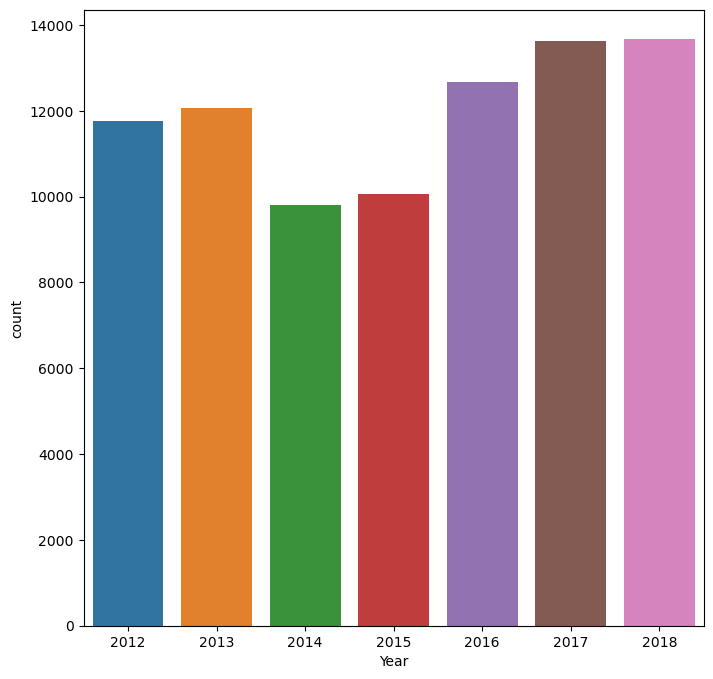

In [18]:
sns.countplot(df.Year)

This distribution is fine to train the model on all the prior years and test it on the last year of study as one common method of testing this kind of model

# Title_I_Status

/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Title_I_Status', ylabel='Grad_Rate'>

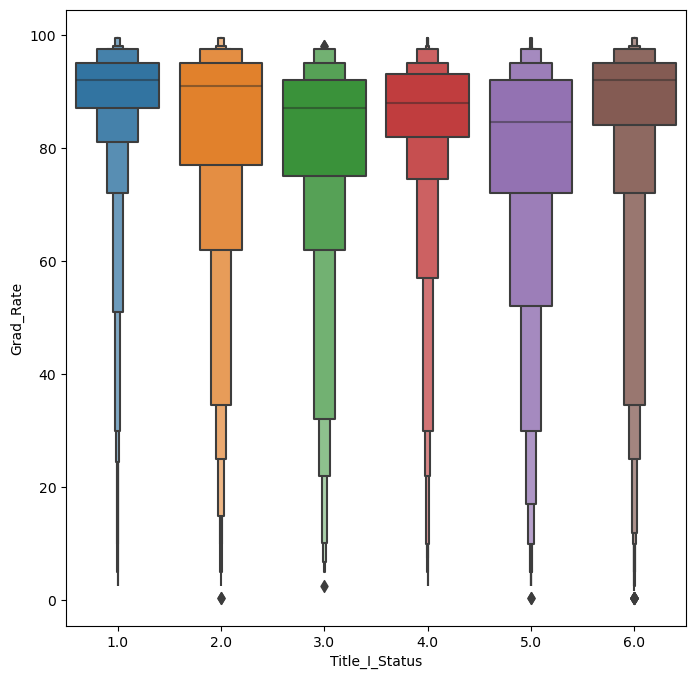

In [19]:
sns.boxenplot(df.Title_I_Status,df.Grad_Rate)

# Pairplot To Visualize Linear Correlations and Outliers

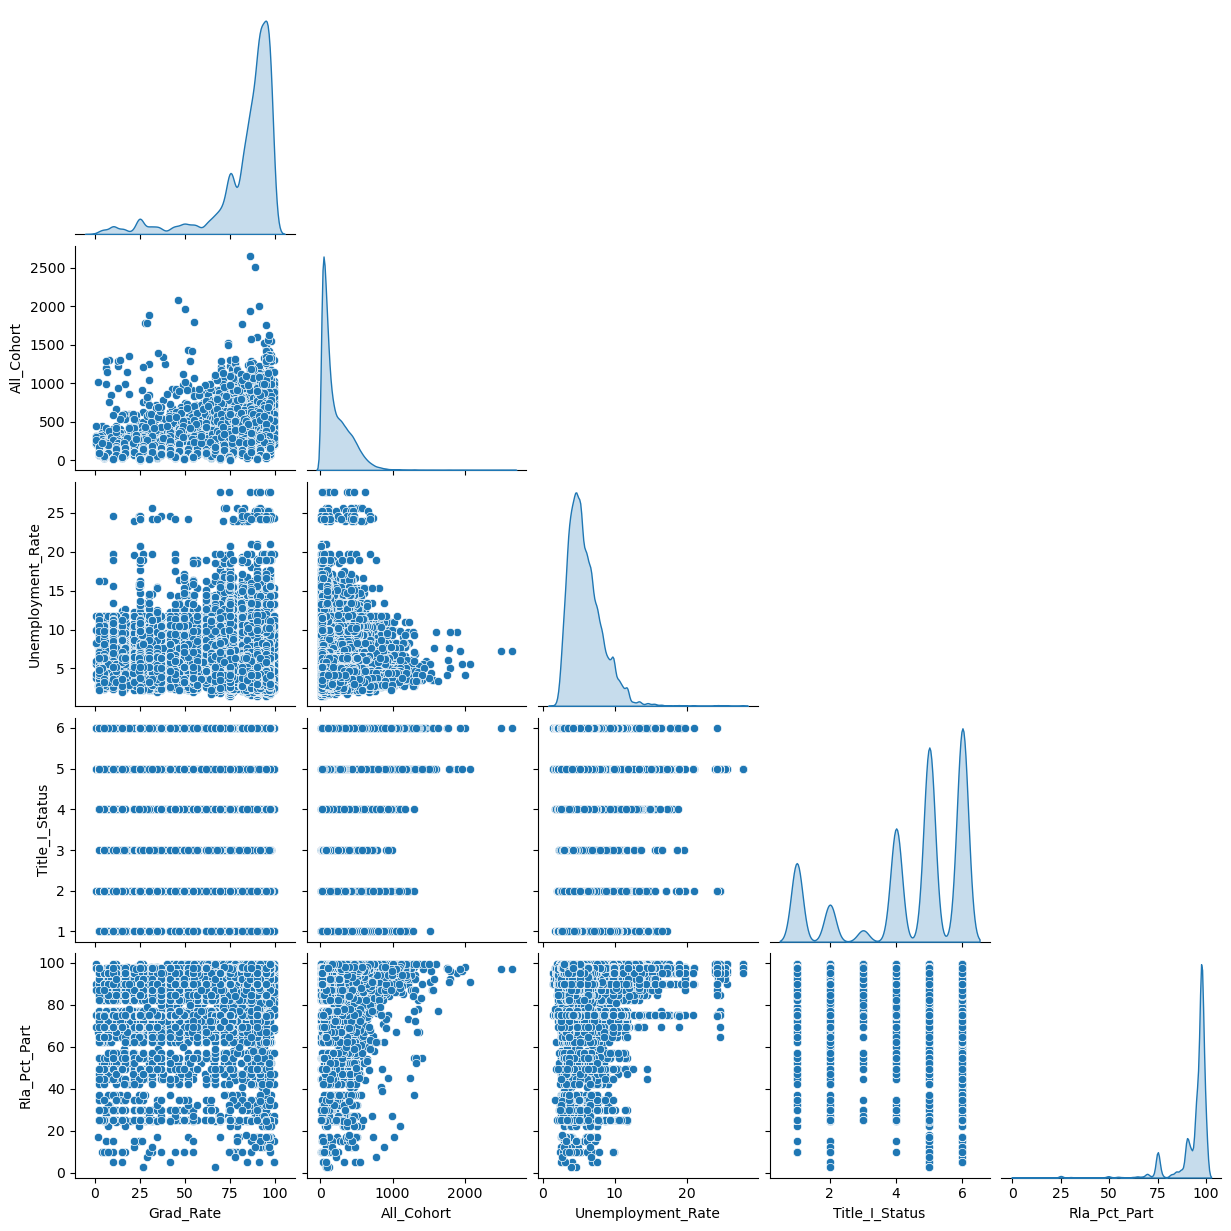

In [20]:
sns.pairplot(df[['Grad_Rate','All_Cohort', 'Unemployment_Rate','Title_I_Status','Rla_Pct_Part']],corner=True,diag_kind='kde')

# Observations
* Grad Rate looks to be pretty complex and non-linear
* Unemployment rate has positive correlation with Reading Language Assessment Participation
* Unemplment rate looks somewhat positive correlation with grad rate

# Open Questions
* Our dataset appears to be similar in distribution to the total distribution of public high schools in the U.S., 
but we should statistically assess this.